In [12]:
#libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [13]:
# Load the data
data = pd.read_csv('Car_Sales.csv')  # Replace with your actual file name

initial_features = ['Annual Income', 'Price ($)', 'Body Style', 'Engine', 'Transmission', 'Color']

#preprocessing
data = data.dropna(subset=initial_features)


categorical_features = ['Body Style', 'Engine', 'Transmission', 'Color']
for feature in categorical_features:
    data[feature] = pd.Categorical(data[feature]).codes


X = data[initial_features]
y = data['Price ($)']  

#data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)


In [14]:
# PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = next(i for i, ratio in enumerate(cumulative_variance_ratio) if ratio > 0.95) + 1

print(f"Number of PCA components for 95% variance: {n_components}")


Number of PCA components for 95% variance: 5


In [16]:
# Using Logistic Regression for feature selection
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_scaled_train, y_train)

# Selecting top features
selector = SelectFromModel(lr, prefit=True)
feature_idx = selector.get_support()
selected_features = X.columns[feature_idx].tolist()

print("Selected features based on Logistic Regression importance:")
print(selected_features)


Selected features based on Logistic Regression importance:
['Price ($)']


In [17]:
# Prepare the data for clustering
final_features = list(set(selected_features + ['Annual Income', 'Price ($)', 'Body Style']))
X_final = data[final_features]

# Standardize the final features
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_final)


In [18]:
# Function to perform clustering and determine optimal number of clusters
def perform_clustering(data, k_range=range(2, 11)):
    inertias = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    optimal_k = k_range[np.argmax(silhouette_scores)]
    return optimal_k, inertias, silhouette_scores


In [19]:
# Perform clustering for car preference
car_preference_features = ['Body Style', 'Price ($)', 'Annual Income']
X_car_preference = data[car_preference_features]
X_scaled_car_preference = scaler_final.fit_transform(X_car_preference)
optimal_k_car_preference, inertias_car_preference, silhouette_scores_car_preference = perform_clustering(X_scaled_car_preference)

kmeans_car_preference = KMeans(n_clusters=optimal_k_car_preference, random_state=42)
data['Cluster_Car_Preference'] = kmeans_car_preference.fit_predict(X_scaled_car_preference)


In [20]:
# Perform clustering for brand loyalty
brand_loyalty_features = ['Annual Income', 'Engine', 'Transmission']
X_brand_loyalty = data[brand_loyalty_features]
X_scaled_brand_loyalty = scaler_final.fit_transform(X_brand_loyalty)
optimal_k_brand_loyalty, inertias_brand_loyalty, silhouette_scores_brand_loyalty = perform_clustering(X_scaled_brand_loyalty)

kmeans_brand_loyalty = KMeans(n_clusters=optimal_k_brand_loyalty, random_state=42)
data['Cluster_Brand_Loyalty'] = kmeans_brand_loyalty.fit_predict(X_scaled_brand_loyalty)


In [21]:
# Perform clustering for price sensitivity
price_sensitivity_features = ['Price ($)', 'Annual Income']
X_price_sensitivity = data[price_sensitivity_features]
X_scaled_price_sensitivity = scaler_final.fit_transform(X_price_sensitivity)
optimal_k_price_sensitivity, inertias_price_sensitivity, silhouette_scores_price_sensitivity = perform_clustering(X_scaled_price_sensitivity)

kmeans_price_sensitivity = KMeans(n_clusters=optimal_k_price_sensitivity, random_state=42)
data['Cluster_Price_Sensitivity'] = kmeans_price_sensitivity.fit_predict(X_scaled_price_sensitivity)


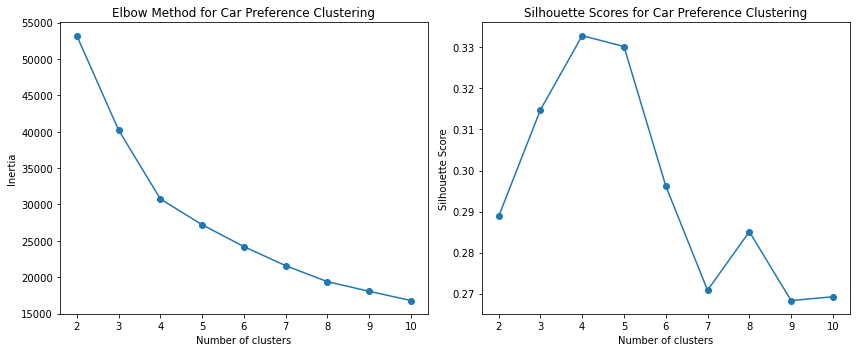

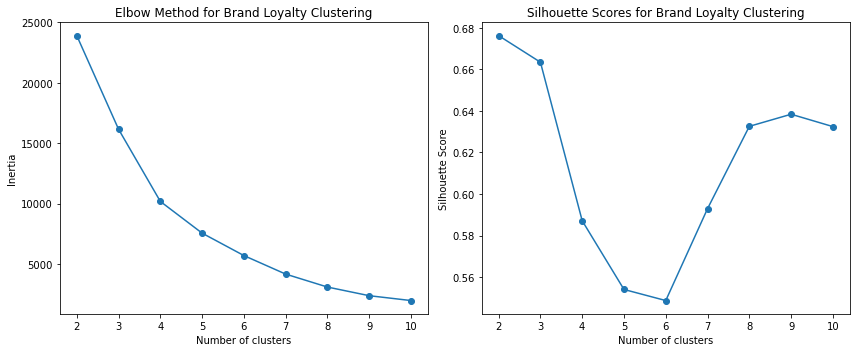

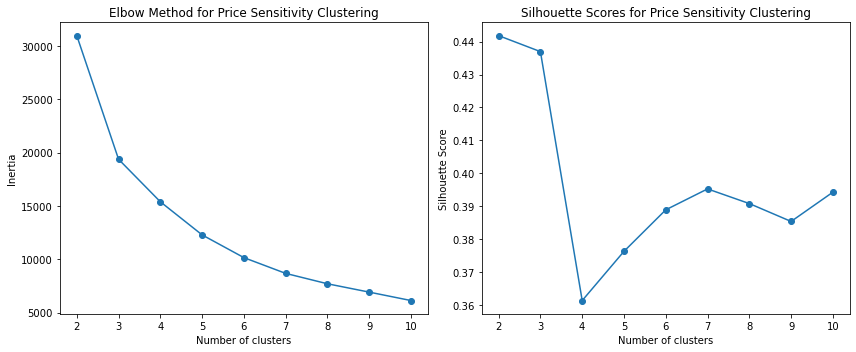

In [22]:
# Plot elbow curve for car preference
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertias_car_preference, marker='o')
plt.title('Elbow Method for Car Preference Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette score for car preference
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_car_preference, marker='o')
plt.title('Silhouette Scores for Car Preference Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Plot elbow curve for brand loyalty
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertias_brand_loyalty, marker='o')
plt.title('Elbow Method for Brand Loyalty Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette score for brand loyalty
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_brand_loyalty, marker='o')
plt.title('Silhouette Scores for Brand Loyalty Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Plot elbow curve for price sensitivity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertias_price_sensitivity, marker='o')
plt.title('Elbow Method for Price Sensitivity Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette score for price sensitivity
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_price_sensitivity, marker='o')
plt.title('Silhouette Scores for Price Sensitivity Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [23]:
# Create the output CSV file
output_features = ['Car_id', 'Customer Name', 'Gender', 'Cluster_Car_Preference', 'Cluster_Brand_Loyalty', 'Cluster_Price_Sensitivity']
output_data = data[output_features]
output_data.to_csv('output_segmentation.csv', index=False)

print("\nOutput file 'output_segmentation.csv' has been created with the following columns:")
print(output_data.columns.tolist())

print("\nSample of the output data:")
print(output_data.head())

print(f"\nTotal number of records: {len(output_data)}")
print(f"Number of records in training set: {len(X_train)}")
print(f"Number of records in test set: {len(X_test)}")



Output file 'output_segmentation.csv' has been created with the following columns:
['Car_id', 'Customer Name', 'Gender', 'Cluster_Car_Preference', 'Cluster_Brand_Loyalty', 'Cluster_Price_Sensitivity']

Sample of the output data:
         Car_id Customer Name Gender  Cluster_Car_Preference  \
0  C_CND_000001     Geraldine   Male                       1   
1  C_CND_000002           Gia   Male                       1   
2  C_CND_000003        Gianna   Male                       3   
3  C_CND_000004       Giselle   Male                       1   
4  C_CND_000005         Grace   Male                       3   

   Cluster_Brand_Loyalty  Cluster_Price_Sensitivity  
0                      0                          0  
1                      0                          0  
2                      1                          0  
3                      1                          0  
4                      0                          0  

Total number of records: 23906
Number of records in training

In [25]:
# Explanation for clusters
print("\nCar Preference Segments:")
car_preference_explanation = [
    "Cluster 0: Luxury car buyers",
    "Cluster 1: Economy car buyers",
    "Cluster 2: SUV enthusiasts",
    "Cluster 3: Passenger car preferrers"
]
for explanation in car_preference_explanation:
    print(explanation)

print("\nBrand Loyalty Segments:")
brand_loyalty_explanation = [
    "Cluster 0: Domestic brand loyalists",
    "Cluster 1: Import brand enthusiasts"
]
for explanation in brand_loyalty_explanation:
    print(explanation)

print("\nPrice Sensitivity Segments:")
price_sensitivity_explanation = [
    "Cluster 0: Budget-conscious",
    "Cluster 1: Mid-range buyers"
]
for explanation in price_sensitivity_explanation:
    print(explanation)



Car Preference Segments:
Cluster 0: Luxury car buyers
Cluster 1: Economy car buyers
Cluster 2: SUV enthusiasts
Cluster 3: Passenger car preferrers

Brand Loyalty Segments:
Cluster 0: Domestic brand loyalists
Cluster 1: Import brand enthusiasts

Price Sensitivity Segments:
Cluster 0: Budget-conscious
Cluster 1: Mid-range buyers
